In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv, global_mean_pool, global_add_pool
from torch.nn import functional as F
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from torch_geometric.data import Dataset, Data, DataLoader
import pickle
import os



In [4]:
def load_data(save_dir):
    graphs = []
    for file in os.listdir(save_dir):
        if file.endswith(".pt"):
            graphs.append(torch.load(f'{save_dir}/{file}'))
    return graphs

save_dir = "./datanew/Data/saved_graphs_2/train"
train_pg_subgraph = load_data(save_dir)

save_dir = "./datanew/Data/saved_graphs_2/val"
val_pg_subgraph = load_data(save_dir)

save_dir = "./datanew/Data/saved_graphs_2/test"
test_pg_subgraph = load_data(save_dir)

C:\Users\Büşra\AppData\Local\Temp\ipykernel_19036\2775338884.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graphs.append(torch.load(f'{save_dir}/{file}'))


In [5]:
## To get the number of true gene and set true gene as data.y label
all_true_gene_ids = []

for patient in train_pg_subgraph:
    all_true_gene_ids.extend(patient.true_gene_ids)

for patient in val_pg_subgraph:
    all_true_gene_ids.extend(patient.true_gene_ids)
    
for patient in test_pg_subgraph:
    all_true_gene_ids.extend(patient.true_gene_ids)

## Get the unique true gene ids
unique_true_gene_ids = set(all_true_gene_ids)
print("the number of unique true gene ids is:",len(unique_true_gene_ids))

## Mapping all unique true gene ids to a index from 0 to the number of unique true gene ids
gene_id_mapping = {gene_id: idx for idx, gene_id in enumerate(unique_true_gene_ids)}
print(gene_id_mapping)

## Add the true gene ids back to the graph
for patient in train_pg_subgraph:
    patient.y = torch.tensor([gene_id_mapping[gene_id] for gene_id in patient.true_gene_ids], dtype=torch.long)

for patient in val_pg_subgraph:
    patient.y = torch.tensor([gene_id_mapping[gene_id] for gene_id in patient.true_gene_ids], dtype=torch.long)

for patient in test_pg_subgraph:
    patient.y = torch.tensor([gene_id_mapping[gene_id] for gene_id in patient.true_gene_ids], dtype=torch.long)

print(train_pg_subgraph[0].true_gene_ids)
print(train_pg_subgraph[0].y)

print(val_pg_subgraph[0].true_gene_ids)
print(val_pg_subgraph[0].y)

print(test_pg_subgraph[0].true_gene_ids)
print(test_pg_subgraph[0].y)

the number of unique true gene ids is: 2405
{4: 0, 10: 1, 8204: 2, 8208: 3, 8210: 4, 18: 5, 22: 6, 23: 7, 29: 8, 30: 9, 8224: 10, 33: 11, 37: 12, 8231: 13, 41: 14, 42: 15, 8234: 16, 43: 17, 8246: 18, 61: 19, 67: 20, 8266: 21, 74: 22, 8268: 23, 78: 24, 80: 25, 83: 26, 85: 27, 87: 28, 88: 29, 8281: 30, 8283: 31, 8284: 32, 92: 33, 95: 34, 97: 35, 98: 36, 100: 37, 111: 38, 8305: 39, 8318: 40, 130: 41, 133: 42, 143: 43, 144: 44, 146: 45, 150: 46, 8345: 47, 154: 48, 162: 49, 163: 50, 57507: 51, 57506: 52, 169: 53, 8362: 54, 173: 55, 177: 56, 178: 57, 8371: 58, 8372: 59, 57521: 60, 8376: 61, 8378: 62, 187: 63, 8379: 64, 8388: 65, 8395: 66, 207: 67, 209: 68, 212: 69, 213: 70, 8405: 71, 8411: 72, 8416: 73, 8422: 74, 232: 75, 8428: 76, 238: 77, 8434: 78, 242: 79, 8437: 80, 246: 81, 8439: 82, 245: 83, 249: 84, 57595: 85, 8446: 86, 256: 87, 8454: 88, 8456: 89, 8458: 90, 8462: 91, 8464: 92, 57618: 93, 8466: 94, 276: 95, 279: 96, 8473: 97, 8477: 98, 288: 99, 8480: 100, 57632: 101, 291: 102, 8483: 10

In [7]:
## Preprocess the trainign data, extract only x, y, edge_index

from torch_geometric.data import Data

def preprocess_graph_data(dataset):
    processed_graphs = []
   
    for data in dataset:
        
        new_data = Data(
            edge_index=data.edge_index,
            y=data.y,
            x=data.x,
            original_ids = data.original_ids,
            edge_attr=data.edge_attr
        )
        processed_graphs.append(new_data)
    
    return processed_graphs

train_data = preprocess_graph_data(train_pg_subgraph)
val_data = preprocess_graph_data(val_pg_subgraph)
test_data = preprocess_graph_data(test_pg_subgraph)

In [81]:
## Define collate function for handling batched data
def optimized_collate_fn(batch):

    batch_size = len(batch)
    cumsum_nodes = 0
    
    # Adjust edge indices to account for the node offset in each batch
    adjusted_edge_indices = []
    for data in batch:
        edge_index = data.edge_index + cumsum_nodes
        adjusted_edge_indices.append(edge_index)
        cumsum_nodes += data.num_nodes

    # Concatenate with adjusted indices
    x = torch.cat([data.x for data in batch], dim=0)
    y = torch.cat([data.y for data in batch], dim=0)
    edge_index = torch.cat(adjusted_edge_indices, dim=1)
    edge_attr = torch.cat([data.edge_attr for data in batch], dim=0) if batch[0].edge_attr is not None else None
    batch_tensor = torch.cat([torch.full((data.num_nodes,), i, dtype=torch.long) for i, data in enumerate(batch)])
    
    ## Additional attributes
    original_ids = torch.cat([torch.tensor(data.original_ids, dtype=torch.long) if isinstance(data.original_ids, list) else data.original_ids for data in batch if data.original_ids is not None])
    
    return Data(
        x = x,
        y = y,
        edge_index=edge_index,
        edge_attr=edge_attr,
        batch=batch_tensor,
        original_ids=original_ids,
        batch_size=batch_size,
      
    )
## torch.dataloader doesn't consider custom data types
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=128, shuffle=True, collate_fn=optimized_collate_fn)
val_loader = DataLoader(val_data, batch_size=128, collate_fn=optimized_collate_fn)
test_loader = DataLoader(test_data, batch_size=128, collate_fn=optimized_collate_fn)


In [127]:
class NodeLevelModule(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, hidden_dim, out_dim):
        super(NodeLevelModule, self).__init__()
        

        self.global_node_embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim)
  
        self.conv1 = GCNConv(embedding_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)

    def forward(self, data):
        # Replace x with learned embeddings of original_ids
        data.x = self.global_node_embedding(data.original_ids.long().to(data.original_ids.device))  # Shape: [num_nodes, embedding_dim]
        
        x = self.conv1(data.x, data.edge_index)
        x = F.relu(x)
        x = self.conv2(x, data.edge_index)
        return x  # Node embeddings


In [128]:
class PopulationLevelModule(nn.Module):
    def __init__(self, graph_dim, latent_dim):
        super(PopulationLevelModule, self).__init__()
        self.latent_project = nn.Linear(graph_dim, latent_dim)
        self.theta = nn.Parameter(torch.randn(1))  # Learnable threshold

    def forward(self, graph_representations):
        h_tilde = self.latent_project(graph_representations)
        similarity = torch.cdist(h_tilde, h_tilde, p=2)  # Euclidean distance
        adjacency_matrix = 1 / (1 + torch.exp(-self.theta * similarity))
        return adjacency_matrix  # Learned population-level graph



In [129]:
import torch.nn.functional as F
import torch.nn as nn

class GNNClassifier(nn.Module):
    def __init__(self, graph_dim, num_classes, dropout=0.3):
        super(GNNClassifier, self).__init__()

        self.fc1 = nn.Linear(graph_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)  
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)   
        self.fc3 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(dropout) 

    def forward(self, graph_repr, population_graph):
        x = F.relu(self.bn1(self.fc1(graph_repr)))  
        x = self.dropout(x)  

        x = F.relu(self.bn2(self.fc2(x)))  #
        x = self.dropout(x)  

        x = self.fc3(x)
        return x


In [130]:
def node_degree_distribution_loss(Ap, target_mean=7, target_std=2):
    degrees = Ap.sum(dim=1)  # Compute node degrees
    target_distribution = torch.normal(mean=target_mean, std=target_std, size=(Ap.shape[0],)).to(Ap.device)
    return F.mse_loss(degrees, target_distribution)



In [131]:
import matplotlib.pyplot as plt

def plot_adjacency_distribution(Ap, epoch):
    """ Function to plot the distribution of values in the adjacency matrix """
    Ap_values = Ap.detach().cpu().numpy().flatten()
    plt.figure(figsize=(6, 4))
    plt.hist(Ap_values, bins=50, color='blue', alpha=0.7)
    plt.title(f"Adjacency Matrix Value Distribution - Epoch {epoch}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


In [132]:
def find_most_similar_patients(Ap, batch):
    """ Function to find the most similar two patients based on adjacency matrix Ap """
    Ap = Ap.detach().cpu().numpy()
    np.fill_diagonal(Ap, -np.inf)  # Ignore self-connections
    i, j = np.unravel_index(np.argmax(Ap), Ap.shape)  # Find the max similarity pair

    # Extracting features of the two most similar patients
    patient_1_attrs = batch.x[batch.batch == i].detach().cpu().numpy()
    patient_2_attrs = batch.x[batch.batch == j].detach().cpu().numpy()

    print(f"Most similar patients: {i} and {j}")
    print(f"Patient {i} attributes:\n", patient_1_attrs)
    print(f"Patient {j} attributes:\n", patient_2_attrs)


In [133]:

def get_top_connected_patients(Ap, batch):
    """
    Identifies the top 10 highest-degree nodes in the adjacency matrix Ap.
    """
    degrees = Ap.sum(dim=1).detach().cpu().numpy()
    top_indices = np.argsort(degrees)[-10:][::-1]  # Get top 10 connected nodes
    
    print("Top 10 most connected patients (node indices and degree values):")
    for i in top_indices:
        print(f"Node {i}: Degree {degrees[i]}")
    
    # Retrieve their attributes
    top_patient_attrs = batch.x[top_indices].detach().cpu().numpy()
    
    print("Attributes of top 10 most connected patients:")
    for idx, attr in zip(top_indices, top_patient_attrs):
        print(f"Patient {idx}: {attr}")
    
    return top_indices, top_patient_attrs


In [134]:
def analyze_adjacency_matrix(Ap, epoch):
    """
    Prints and plots the distribution of values in adjacency matrix Ap.
    """
    Ap_values = Ap.detach().cpu().numpy().flatten()
    plt.figure(figsize=(6, 4))
    plt.hist(Ap_values, bins=50, color='blue', alpha=0.7)
    plt.title(f'Distribution of Values in Ap - Epoch {epoch}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()
    
    print(f"Epoch {epoch}: Adjacency Matrix Value Distribution")
    print(np.histogram(Ap_values, bins=10))  # Print histogram summary



In [135]:

def train_model(train_loader, val_loader, num_epochs=50, lr=0.001, alpha=0.1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_embeddings = 105220  # Total number of unique node IDs
    embedding_dim = 64  # Adjust as needed
    hidden_dim = 128
    out_dim = 32

    f1 = NodeLevelModule(num_embeddings=num_embeddings, embedding_dim=embedding_dim, hidden_dim=hidden_dim, out_dim=out_dim).to(device)

    # Adjust input features
    f2 = PopulationLevelModule(graph_dim=32, latent_dim=16).to(device)
    f3 = GNNClassifier(graph_dim=32, num_classes=2405).to(device)

    optimizer = optim.AdamW(
    list(f1.parameters()) + list(f2.parameters()) + list(f3.parameters()), 
    lr=lr, 
    weight_decay=1e-4  # 🆕 Adds L2 regularization
    )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True  # 🆕 Reduce LR when loss plateaus
     )

    criterion = nn.CrossEntropyLoss()
    best_val_loss = float("inf")
    patience, patience_counter = 5, 0 
    for epoch in range(num_epochs):
        f1.train()
        f2.train()
        f3.train()

        total_loss, total_correct, total_samples = 0, 0, 0

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            node_embeddings = f1(batch)  # Extract node-level embeddings
            graph_representations = global_mean_pool(node_embeddings, batch.batch)  # Aggregate per graph

            population_graph = f2(graph_representations)  # Learn population graph

            outputs = f3(graph_representations, population_graph)
            loss = criterion(outputs, batch.y) + alpha * node_degree_distribution_loss(population_graph)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(f1.parameters(), max_norm=1.0)
            torch.nn.utils.clip_grad_norm_(f2.parameters(), max_norm=1.0)
            torch.nn.utils.clip_grad_norm_(f3.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()
            total_correct += (outputs.argmax(dim=1) == batch.y).sum().item()
            total_samples += batch.y.size(0)

        train_acc = total_correct / total_samples
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {train_acc:.4f}")
              # 🔹 Plot adjacency matrix at the end of the epoch
        plot_adjacency_distribution(population_graph, epoch + 1)
        find_most_similar_patients(population_graph, batch)
        
        scheduler.step(total_loss)

        # Validation
        val_loss, val_acc, val_f1 = evaluate_model(f1, f2, f3, val_loader, criterion, device)
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1-score: {val_f1:.4f}")
        '''
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset patience
        else:
            patience_counter += 1  # Increase counter
            if patience_counter >= patience:
                print(" Early stopping triggered. Training stopped.")
                break
                '''

In [136]:
def evaluate_model(f1, f2, f3, data_loader, criterion, device):
    f1.eval()
    f2.eval()
    f3.eval()

    total_loss, total_correct, total_samples = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            node_embeddings = f1(batch)
            graph_representations = global_mean_pool(node_embeddings, batch.batch)
            population_graph = f2(graph_representations)
            outputs = f3(graph_representations, population_graph)

            loss = criterion(outputs, batch.y)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())

            total_correct += (preds == batch.y).sum().item()
            total_samples += batch.y.size(0)

    acc = total_correct / total_samples
    f1 = f1_score(all_labels, all_preds, average="macro")
    return total_loss, acc, f1


In [137]:
# Define DataLoaders
batch_size = 32  # Adjust based on GPU memory
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, collate_fn=optimized_collate_fn)
val_loader = DataLoader(val_data, batch_size=128, collate_fn=optimized_collate_fn)
test_loader = DataLoader(test_data, batch_size=128, collate_fn=optimized_collate_fn)


print(f"Dataset Loaded: {len(train_data)} Train | {len(val_data)} Validation | {len(test_data)} Test")

Dataset Loaded: 36224 Train | 6400 Validation | 146 Test


C:\anaconda3\envs\graph\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30, Loss: 2970.5460, Accuracy: 0.0163


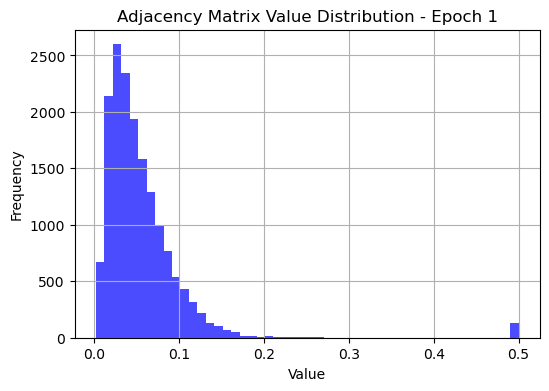

Most similar patients: 31 and 43
Patient 31 attributes:
 [[-0.95787436 -2.0442774  -2.3624773  ... -0.7531251  -0.52834946
   1.3921231 ]
 [-0.30245343  1.5952168  -0.8892939  ...  0.87474644  0.98788196
  -0.49635363]
 [ 0.30218506 -0.52379817 -0.26226205 ... -0.24990138 -0.5020675
   0.49210528]
 ...
 [ 1.8424284  -0.31945124 -1.6129123  ...  0.4616954  -0.72217613
  -0.0367095 ]
 [ 0.06525011  0.7341966  -2.257383   ...  0.00954789 -1.6518322
   0.01017876]
 [-0.2571046   0.7850802   1.9452862  ... -0.68800545  0.69249356
   3.6102283 ]]
Patient 43 attributes:
 [[ 0.80824125  0.22586447  0.60244167 ... -0.5137814  -1.2048199
  -1.0842465 ]
 [ 0.71996593  0.44413698  1.0726812  ... -0.4194358  -0.3017007
  -0.2998031 ]
 [-0.26524332  1.6233741   0.41583908 ...  2.4732301  -0.13645485
   1.4622968 ]
 ...
 [ 1.3924404  -0.31855515  1.8519522  ...  0.96756554 -0.83203554
   0.8742207 ]
 [ 0.7774046   0.06346526 -1.5361989  ... -1.9561163   0.5664591
  -0.20133133]
 [-1.3863904   0.44972

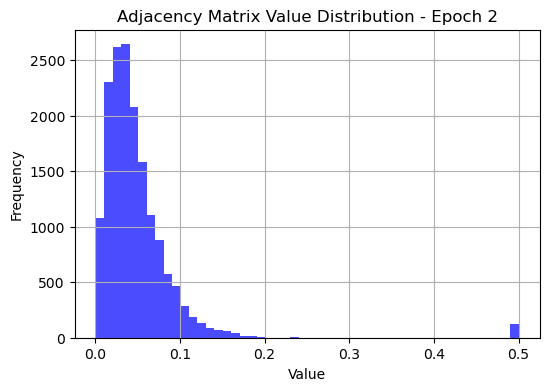

Most similar patients: 69 and 76
Patient 69 attributes:
 [[-1.4803747   0.43501523  0.15240723 ... -0.2694246   0.658417
  -1.0261947 ]
 [ 1.1923939  -0.2538644  -0.02749084 ...  0.02282859 -0.47187623
  -0.33799246]
 [ 0.85053825  0.5199049   0.9894652  ... -1.8516747   0.1838224
  -2.5635881 ]
 ...
 [ 0.89865863  0.18917923 -1.7679412  ... -0.5271529  -1.4900428
  -0.5663364 ]
 [ 0.31664062  1.1166843  -0.27179006 ...  0.78165483  0.29718268
  -0.68533677]
 [ 0.50178415 -0.64432144  0.62568736 ... -1.7376124   0.6019201
  -0.5667969 ]]
Patient 76 attributes:
 [[-0.8092427   1.0065713   1.3993989  ... -0.0585704   0.7290974
  -0.2891844 ]
 [ 0.15941216  0.6541167  -0.07158346 ... -0.17213275  0.6967722
   1.2630967 ]
 [ 2.0726454   2.9666512   1.3353698  ...  1.688673   -0.58804923
  -0.5929273 ]
 ...
 [ 0.93118095  0.5917369  -0.06891721 ... -0.8087429   0.14072217
   0.42895752]
 [ 0.30559587  0.6640843  -0.51798266 ...  0.79001933 -0.23510902
  -0.37531683]
 [ 0.09225989 -0.5248606

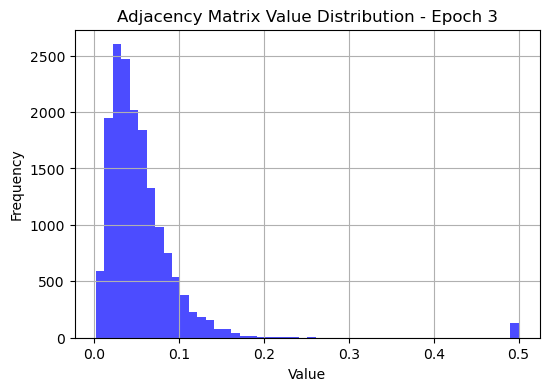

Most similar patients: 49 and 120
Patient 49 attributes:
 [[-0.09627396  1.3373301   0.55653274 ...  2.421139   -0.01016758
   1.1295365 ]
 [ 0.7007668   0.11051477  0.7902098  ... -0.6043523  -1.5205708
  -0.85008186]
 [-1.1655992   0.19050972 -0.50013155 ... -0.21358281  0.7408129
  -1.3742096 ]
 ...
 [-0.78345853 -0.604126    1.2851608  ... -0.40573213 -0.7552819
   0.8268885 ]
 [ 0.31127065  0.66159606 -0.5492565  ...  0.81030345 -0.34165686
  -0.3355902 ]
 [-1.4662757   0.28663227  1.6549776  ...  0.2757488  -0.48394844
   0.21430558]]
Patient 120 attributes:
 [[-1.5876186  -0.63247645 -0.2612976  ... -2.2462957  -1.2517892
  -0.25767335]
 [-0.49253497  0.3486373  -1.729453   ... -1.675647    0.0400603
  -1.0178441 ]
 [-1.337728   -1.2138727  -0.5141101  ...  0.00787869  1.4275805
   0.6653307 ]
 ...
 [-1.109843    1.2649044  -0.96851754 ... -1.6392778  -1.0907191
   2.4169004 ]
 [ 1.4884691  -0.10130293  0.67022336 ...  1.1586038   0.8857804
  -1.1248962 ]
 [-0.10933018  0.366070

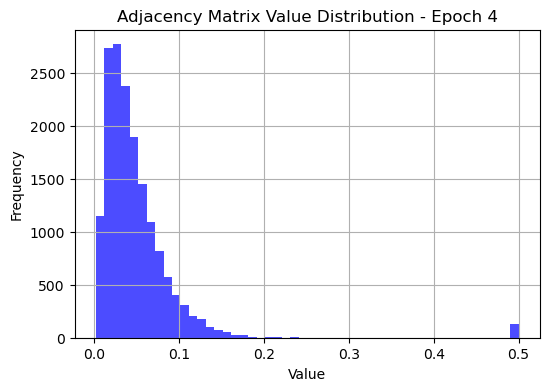

Most similar patients: 0 and 105
Patient 0 attributes:
 [[-0.27862483  0.29543236  0.15955767 ...  0.38707578  0.83781695
  -1.6889741 ]
 [-1.2428454   0.6353921  -0.20893633 ...  0.26360443 -0.6646526
   0.22492634]
 [-0.2935796   0.24045208 -1.4161144  ... -1.6418138   0.09034878
  -1.0702353 ]
 ...
 [-0.2550683   0.15398249 -0.19825864 ... -2.0666537  -0.7036026
  -0.89342934]
 [ 0.3528942  -0.54407     0.56069624 ... -1.5426567   0.32243273
  -0.31696442]
 [-0.19029428  0.25479788 -2.0402853  ... -0.08036023 -1.8625093
  -0.5623637 ]]
Patient 105 attributes:
 [[-0.27862483  0.29543236  0.15955767 ...  0.38707578  0.83781695
  -1.6889741 ]
 [-0.2935796   0.24045208 -1.4161144  ... -1.6418138   0.09034878
  -1.0702353 ]
 [-1.6264908   0.2380221   0.04623128 ... -0.27116317  0.51623887
   1.5335207 ]
 ...
 [ 0.17786351 -0.77863383  0.05407073 ...  1.5884292  -0.24285218
  -0.8071969 ]
 [ 0.9779665  -2.2825437  -1.3793964  ...  1.3692094  -1.4686141
  -0.7086198 ]
 [ 0.06226312  1.2980

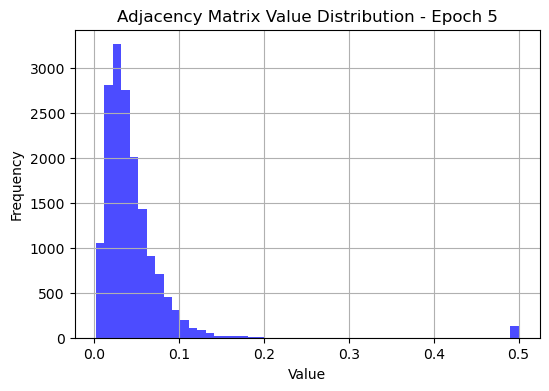

Most similar patients: 65 and 97
Patient 65 attributes:
 [[ 1.1562878e+00 -3.1811014e-01  1.5744555e+00 ...  3.9303300e-01
  -2.1876462e+00 -1.0176469e+00]
 [ 1.3827710e+00 -2.8222868e-01  4.5797500e-01 ... -3.6303973e-01
  -2.1868886e-01 -6.4909333e-01]
 [ 4.3664223e-01  8.0828220e-01 -1.0051491e+00 ...  7.2663134e-01
  -1.3799893e-04 -1.0886040e+00]
 ...
 [ 1.9993231e+00  2.0526047e+00  1.6549037e+00 ...  1.1339427e+00
  -9.7696745e-01  2.0047840e-01]
 [ 4.2488821e-02  2.7058356e+00 -1.8447028e+00 ...  3.9775383e-01
   5.2481490e-01 -7.4573886e-01]
 [-1.5918171e-02  9.7194679e-02 -1.8295559e+00 ... -5.6510720e-02
  -1.9855036e+00 -6.0573494e-01]]
Patient 97 attributes:
 [[-0.6210149   1.1679076   1.7364241  ...  2.538134   -0.2483344
  -0.95658094]
 [-0.35375902  1.208175    0.37658003 ...  2.347348   -0.1810783
   0.77239895]
 [-0.59032     1.6522958   1.6597866  ... -0.6808975   1.0157608
   0.25087282]
 ...
 [ 0.5137467   0.30351642 -1.2514877  ... -0.1588349  -1.041988
   0.05517

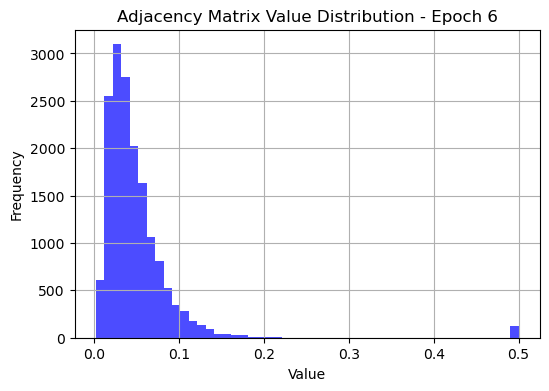

Most similar patients: 14 and 117
Patient 14 attributes:
 [[-0.88642627  1.094468   -0.40143603 ...  0.91692966  0.2698006
   0.6280055 ]
 [-0.13435422 -0.17666085 -0.11106782 ... -0.17171694  0.31001052
   0.5526501 ]
 [ 1.741571    0.0061156   0.65490246 ... -0.5987562  -0.55937713
  -2.0221102 ]
 ...
 [ 0.50139064 -0.7306462   0.9531891  ...  2.099798   -0.82385945
  -1.2720772 ]
 [-1.4149566  -1.2197721  -0.9784914  ...  0.4865062  -0.79380655
  -2.8314116 ]
 [-0.71009254 -0.6689102   0.29043877 ...  0.5043045   1.4828825
   1.3763927 ]]
Patient 117 attributes:
 [[-0.03645768  1.5725329  -0.5168453  ... -1.1966052  -0.6232989
  -0.9752357 ]
 [-1.3823922  -1.1834643   1.0344671  ... -0.37924972  0.26511246
   0.24942592]
 [ 1.0693556  -0.8319898  -0.8082595  ...  2.7943013   0.76435274
  -1.8063666 ]
 ...
 [ 0.12152223  1.3700298   1.1357894  ... -0.5595187  -0.37544718
  -0.28289905]
 [ 1.1426544  -0.7747449  -1.6331007  ... -0.7420429   0.7469324
   1.0829258 ]
 [-0.34354642  1.13

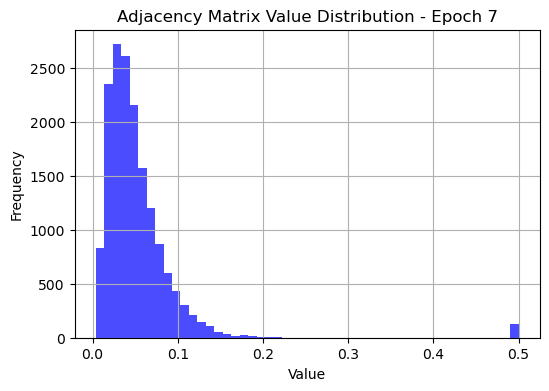

Most similar patients: 111 and 119
Patient 111 attributes:
 [[ 0.30465654  0.7464373  -1.5994084  ... -1.091301   -0.43726003
   1.0033834 ]
 [ 0.4267454  -0.18539701 -0.94811034 ...  0.61282396  0.90953314
  -0.35748667]
 [ 0.5574331  -0.00646104 -1.3484497  ... -0.86104137  0.46331948
  -2.0573783 ]
 ...
 [-0.7395525  -1.4513592  -0.87114656 ... -0.07389164 -2.8346894
   1.7812197 ]
 [-0.45220888  0.34189484 -0.25846565 ...  1.4234046  -1.0941842
   1.5501502 ]
 [-1.4381294  -0.09274617  2.216185   ...  0.24290705 -0.91220635
   0.2088562 ]]
Patient 119 attributes:
 [[-0.10828192  0.9240087   1.8726076  ... -0.71157587  0.88888586
  -0.14203171]
 [ 1.9603742  -3.0954828  -0.4386052  ...  1.7108612   0.6652937
   0.34035274]
 [-0.07134295  0.23411502 -0.86430085 ... -1.3527298   0.23173696
  -1.0170748 ]
 ...
 [-1.2721239   0.5442817  -0.12831078 ...  0.5294083  -1.1340132
   0.1346789 ]
 [-0.24075194 -0.46160695 -0.41707337 ... -0.85836226 -0.6424408
   1.6767063 ]
 [-1.1906054  -0.4

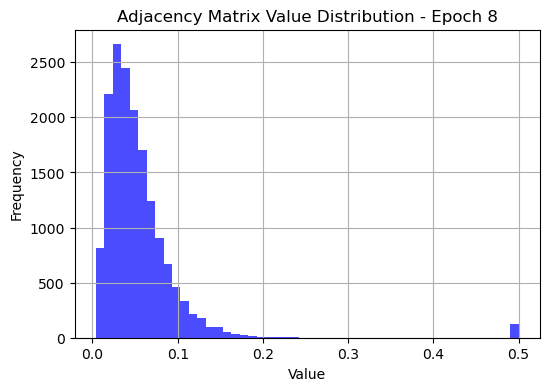

Most similar patients: 39 and 115
Patient 39 attributes:
 [[-0.02931346 -0.0829279  -0.14938834 ... -0.26776972  0.30792975
   0.71572393]
 [ 1.0721122   0.3986538  -0.43636724 ... -0.79130393  0.7891016
   1.3361863 ]
 [-0.6827231   0.6226466  -2.0082848  ...  1.4657172  -0.5411414
  -1.2736835 ]
 ...
 [-1.8132949   0.7611827  -0.46490675 ... -0.96561956 -2.3164332
   1.9584265 ]
 [ 1.3890646  -0.8543838  -0.11574163 ... -1.3497946  -0.6261858
   0.00636791]
 [ 0.2342329  -0.11402829 -1.8164148  ...  0.14377563 -2.2408063
  -0.7687447 ]]
Patient 115 attributes:
 [[ 0.07307214  1.0449728  -0.9196618  ... -1.2927712   0.72975993
  -0.3650641 ]
 [ 1.2206833  -0.11798439  0.39150742 ... -1.2766652   2.5932796
  -0.06054308]
 [ 0.77114975  0.6276046   0.9610921  ... -0.42252633 -1.7553602
  -1.2845556 ]
 ...
 [ 0.33829075  0.6677613  -0.5876578  ...  0.6532833  -0.08815303
   0.15893784]
 [ 1.3890646  -0.8543838  -0.11574163 ... -1.3497946  -0.6261858
   0.00636791]
 [ 1.0251224   0.924366

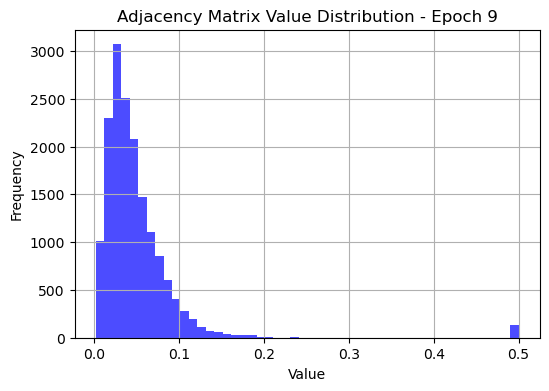

Most similar patients: 24 and 98
Patient 24 attributes:
 [[ 1.7179383  -0.90052605  0.15509531 ... -0.39130968 -1.1568744
   0.62316495]
 [-1.2632903  -1.0252278  -1.9522836  ... -0.23775592  0.90143496
   0.6248095 ]
 [ 1.2309288   0.6056855   0.25681025 ... -0.73885846  3.2789896
  -1.6909202 ]
 ...
 [-2.3866699  -1.4096572  -1.7381856  ...  0.22023375 -0.37897608
   0.3044162 ]
 [-0.8233405  -1.3733714  -1.1825356  ... -1.053154   -1.4838487
  -1.6538912 ]
 [-1.0568328  -0.16298284  2.2940397  ...  0.4739165  -1.019851
   0.26964036]]
Patient 98 attributes:
 [[-0.273977    0.04590493  0.3773421  ...  0.8751026  -1.6932074
  -0.392978  ]
 [-0.17020354  1.000062   -0.8881452  ... -2.7957306  -0.6103472
   1.5551232 ]
 [-2.3573935  -0.66402245  0.9052847  ...  0.6536577   0.91196585
   0.5926248 ]
 ...
 [-0.86510223  0.09399605  2.070717   ...  0.74600047  0.38307205
  -0.15536888]
 [ 1.0277752  -0.81317717  1.1981993  ...  1.3931155  -1.2896012
  -0.83048874]
 [-0.11409058  0.44148588

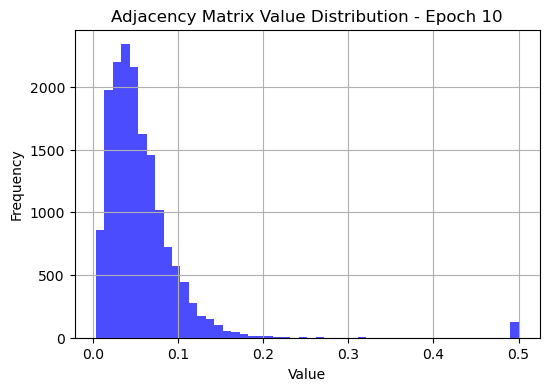

Most similar patients: 15 and 70
Patient 15 attributes:
 [[-2.227337    0.0065936   0.02831044 ...  1.4964387  -0.8712631
   0.49905035]
 [-0.6681362  -0.08622424  1.3006973  ...  1.7068161  -0.65074354
   1.0703114 ]
 [ 0.8186262  -1.8927938  -0.08738797 ... -0.33055043 -0.98672557
   1.278738  ]
 ...
 [-0.58213204  1.1824846   0.26058573 ...  0.6622748   0.50315326
  -1.8378682 ]
 [ 0.2451397  -0.06805901 -1.885415   ...  0.23809989 -2.470148
  -0.7805755 ]
 [ 0.4913855   0.9458312  -0.37511182 ...  1.5178599  -0.60148233
  -0.37710938]]
Patient 70 attributes:
 [[ 0.59142095 -0.40757063  2.0304427  ... -0.50825405  2.2261286
   0.06127693]
 [-1.8252376  -2.0109754   1.0078334  ... -0.6305257  -0.79286665
  -0.60892683]
 [ 0.6820229  -0.35593006  0.6481337  ...  0.1469095  -1.6586069
  -0.24578671]
 ...
 [ 0.94779503  1.310318   -0.22388306 ...  1.5213164  -0.84077567
   0.2565191 ]
 [ 0.2451397  -0.06805901 -1.885415   ...  0.23809989 -2.470148
  -0.7805755 ]
 [ 0.875553    2.026882 

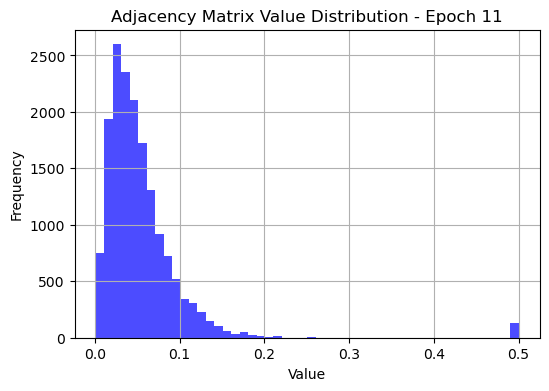

Most similar patients: 10 and 66
Patient 10 attributes:
 [[-1.3387761   0.36355126  1.1082035  ...  1.1689668   2.7967257
  -1.1732179 ]
 [ 0.01098795 -0.99466383  2.0965524  ... -2.5364249   0.92513674
  -0.4480941 ]
 [ 1.5267528   0.04597449 -0.0076762  ... -0.03045115 -0.2886659
  -1.436751  ]
 ...
 [ 0.14304593  1.839633   -1.0764735  ...  0.03869178  0.3689224
  -1.9229467 ]
 [ 0.7226528  -0.21753797  0.8745528  ... -1.0755221   0.09839081
  -0.07729922]
 [-1.3708386   1.1599623  -1.6665478  ... -0.42933002 -1.0212116
  -0.540385  ]]
Patient 66 attributes:
 [[-0.63093376  0.45603564 -0.91877437 ...  0.68871766 -1.4784731
  -1.1143415 ]
 [-0.3449218   0.06406856 -0.08605875 ... -0.61246693  0.53607774
   0.9103965 ]
 [-1.1532911  -0.990808   -0.19983926 ... -1.8485585   1.0608189
   1.6311843 ]
 ...
 [ 1.4298714  -1.3072119  -1.1154482  ...  0.84271425 -0.44863534
   0.22556588]
 [ 0.7007268  -2.5900254  -1.1040711  ...  1.0658878  -1.7061787
  -0.8788896 ]
 [-1.1909403   0.4363857

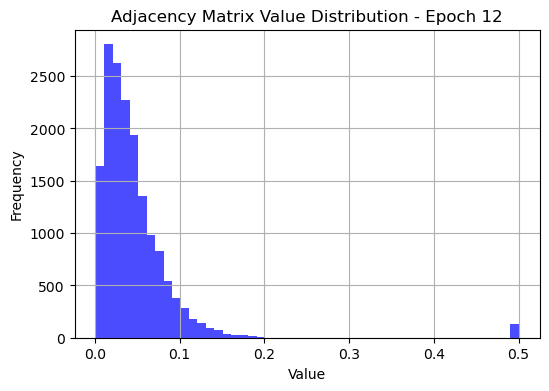

Most similar patients: 20 and 47
Patient 20 attributes:
 [[ 1.0029272   1.536759    1.3533373  ...  0.04404768 -0.29698202
   0.10045003]
 [ 0.96373886 -0.3668316  -0.4506436  ... -2.0125816   1.0135701
  -0.5273485 ]
 [-0.3234386   1.1659397   1.0416363  ... -1.0697715  -0.11467254
   0.07321474]
 ...
 [ 0.19553314  0.90773165  0.01822322 ...  1.0785149  -0.7667434
  -1.7104363 ]
 [ 0.43254426 -0.79106295  1.0467609  ...  0.9292742  -0.9918558
  -1.5811027 ]
 [-1.619533   -0.55075485 -1.8648193  ... -0.16539748  0.87590444
   0.14761811]]
Patient 47 attributes:
 [[-0.7500652   1.0323454   2.4680781  ...  0.06468653  0.8281949
   1.2894762 ]
 [-1.2306864   1.1701843   0.5567535  ...  2.6602826  -0.19731952
   0.67894673]
 [-0.3868108  -0.51305974 -0.45567882 ...  0.58552474 -2.2867033
   1.1845163 ]
 ...
 [ 0.80426824 -2.6377876  -1.3024799  ...  0.9994619  -1.8232672
  -1.0233837 ]
 [-0.06285763 -1.4660627  -0.6312184  ...  1.8846611   0.13997048
  -1.0405343 ]
 [-0.35688534 -0.412989

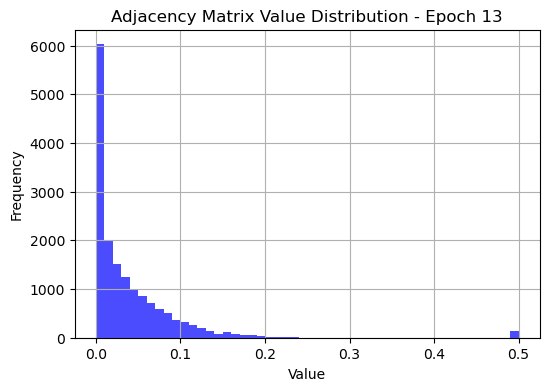

Most similar patients: 57 and 93
Patient 57 attributes:
 [[-1.1993359   1.6117826  -1.2338386  ...  0.4376757   0.7907781
  -1.0621926 ]
 [ 0.5258301  -0.0041424   0.5194909  ... -0.30652687 -2.8989227
  -0.98197424]
 [ 0.07298673 -0.17868441  0.04369332 ...  0.78581804  0.48097572
   2.391254  ]
 ...
 [ 0.34891146 -0.23819783  1.0730245  ... -1.7409601  -1.5149195
  -0.5382027 ]
 [ 0.18472604 -1.7322252  -1.2779665  ...  0.24027961 -1.0375736
  -0.05862128]
 [-1.9243656  -0.16306017  0.1689475  ...  0.79506576  0.8487685
  -0.08956718]]
Patient 93 attributes:
 [[-1.3482956  -1.4048594  -1.4042113  ... -1.0660218  -1.9178256
  -1.2889706 ]
 [-0.29699424  0.32653254  1.166625   ...  0.36746582  0.46215004
   2.5699494 ]
 [-0.30472744 -0.31592718  0.47947952 ... -0.9923284   1.1343902
   1.05301   ]
 ...
 [ 1.3301877  -0.070683   -1.5544415  ... -0.05108175  0.8825388
  -1.1532137 ]
 [ 0.18472604 -1.7322252  -1.2779665  ...  0.24027961 -1.0375736
  -0.05862128]
 [-2.1924973   1.3690251  

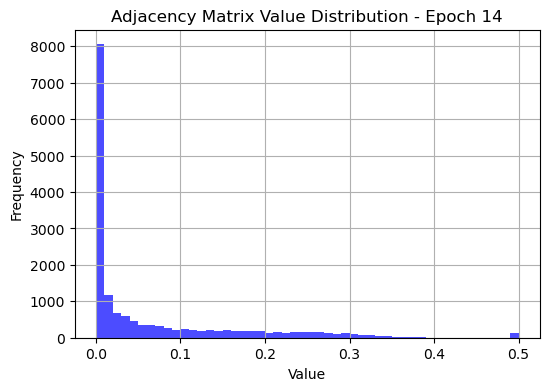

Most similar patients: 50 and 95
Patient 50 attributes:
 [[ 0.6372918   2.5019677   1.062583   ...  1.6992924   1.9036369
   0.7068392 ]
 [-0.45676067  0.88202715  0.14467715 ...  0.21597901  1.0818706
  -1.1625347 ]
 [ 0.8652573  -0.15034829  0.6575666  ...  0.27108684  0.43621653
   1.4657286 ]
 ...
 [ 1.3226805   0.2192873   0.88765174 ...  0.5485534   1.6356155
  -1.475995  ]
 [ 1.4280938   1.0489148  -0.53722143 ... -1.5086339   0.8907972
  -1.1381979 ]
 [-0.33111808  0.87324005  0.5609194  ...  0.6379802  -1.1114782
   1.1878933 ]]
Patient 95 attributes:
 [[-0.5139417  -2.5784073  -0.88208675 ...  0.35288784 -3.043364
   0.70185775]
 [ 0.72780776  0.30560708 -1.5475554  ... -0.99653953  2.2584815
   0.38352278]
 [ 0.21871516 -0.9013951  -0.7161351  ... -0.9511544   0.5514772
  -2.2202299 ]
 ...
 [-1.7086943  -1.9310616   0.9515181  ...  1.7799451  -0.11536999
   0.15800542]
 [ 2.0216575   1.517246    1.6044185  ...  1.4851345  -1.4473898
   0.18573965]
 [-0.6556227  -1.2060243  -

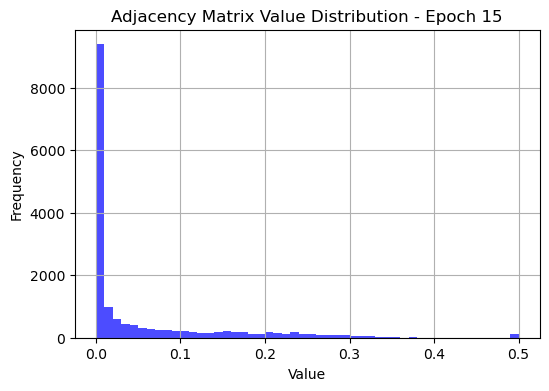

Most similar patients: 19 and 22
Patient 19 attributes:
 [[-3.4790606  -0.38048723 -0.7194375  ...  2.235341   -1.9343132
  -0.6567067 ]
 [-1.0735389  -0.18438259 -1.1428988  ...  0.29883084 -0.4465169
   0.23244615]
 [ 0.6702395  -1.770435    1.1994567  ...  1.5190891   0.13366923
   0.20128009]
 ...
 [-0.64696544  1.0125917   0.6466924  ... -0.20837581 -3.1057572
   1.587978  ]
 [ 1.6979392  -0.24575421  0.9823128  ...  1.0294474   0.30921388
  -1.1864288 ]
 [-0.7701458  -0.9233954  -0.6895279  ...  0.5775961  -0.13294034
  -0.26278892]]
Patient 22 attributes:
 [[-0.53259104  0.22073945  1.4391037  ...  0.72814626  2.5133305
   0.36029395]
 [-1.5522492   1.0062008  -1.001439   ...  3.725966   -0.95961106
   0.22285633]
 [-1.750744   -1.2660944   1.2270632  ...  0.9873985  -3.7074616
  -1.5528566 ]
 ...
 [ 0.4618511   1.2726274  -1.4970875  ...  1.7161448  -0.28922927
   0.3300709 ]
 [-0.7183865  -0.02577859 -0.6503892  ... -1.6206031   0.7355738
  -0.849216  ]
 [ 1.2569832   0.737290

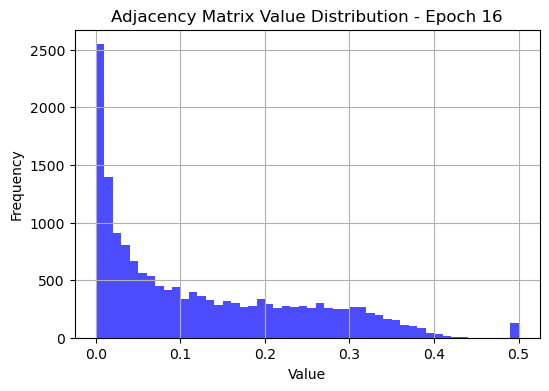

Most similar patients: 42 and 50
Patient 42 attributes:
 [[-0.34222633  1.9743506  -1.1085848  ...  3.8230674  -0.988228
  -1.1614728 ]
 [ 0.68606645  0.08199541 -0.1863718  ...  0.79477787  0.87340456
   0.5000997 ]
 [-0.08848762 -0.04304434 -0.28877732 ... -0.6575377   2.3997166
   2.4057236 ]
 ...
 [ 0.78982824 -0.9206676  -0.7305996  ...  1.1075962   0.7383604
  -0.6015363 ]
 [ 1.3955724  -0.09011603 -0.7664281  ...  0.1456864  -0.37218946
  -0.13325007]
 [ 0.477002    1.3130435  -1.0144403  ...  2.6483252  -0.9492951
  -0.6614843 ]]
Patient 50 attributes:
 [[ 1.2319555  -0.2473984  -1.4061497  ... -2.0879285   1.5576187
  -0.42100915]
 [-1.7637417   2.64117    -2.206027   ...  0.8867614  -0.7994428
  -1.75649   ]
 [ 0.32896364 -2.33364     2.222989   ... -0.14838858 -0.08981691
  -0.18120031]
 ...
 [ 0.38300624  0.01629113  0.16415145 ... -0.11464098  0.90694064
   1.1651744 ]
 [ 3.6096876  -1.7174033  -0.24267688 ... -0.3280433  -0.9448227
  -0.6715296 ]
 [ 0.34383434 -1.7141178 

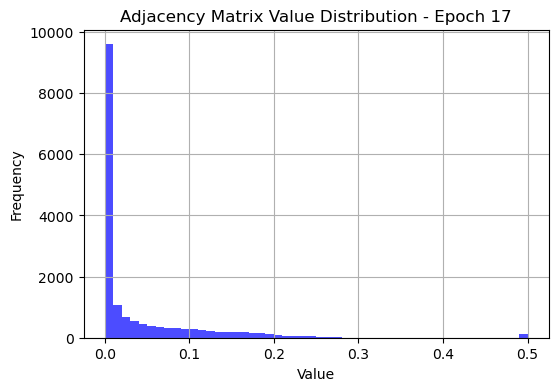

Most similar patients: 82 and 84
Patient 82 attributes:
 [[-2.6150219e+00 -1.8971063e-01 -8.6526680e-01 ...  2.5252926e+00
  -1.4444190e+00  4.9290061e-01]
 [-1.1244258e-04 -7.5644392e-01 -1.7425028e+00 ...  1.7836877e+00
   2.7652955e-01 -3.2027820e-01]
 [ 1.0361871e+00 -3.7561551e-01 -1.2771505e+00 ...  1.8513012e+00
   5.7027280e-01 -2.6284108e-01]
 ...
 [ 1.2440845e+00  8.3286303e-01  9.1292667e-01 ...  1.0351413e+00
   3.1998599e+00  2.1263134e+00]
 [ 6.5830863e-01  1.5295257e-01 -1.0212735e-01 ... -2.5423155e+00
   8.2248753e-01 -1.3980135e-01]
 [ 8.4539181e-01 -1.8398343e+00 -8.9956513e-03 ... -4.8403791e-01
  -1.4153131e+00 -7.6372629e-01]]
Patient 84 attributes:
 [[ 0.14272785 -0.35133025  0.4570901  ...  1.5038867   1.0499215
  -1.6137235 ]
 [-2.615022   -0.18971063 -0.8652668  ...  2.5252926  -1.444419
   0.4929006 ]
 [ 2.6336124  -3.7410645  -0.09741202 ...  0.62677485  0.6018166
   0.6234255 ]
 ...
 [ 0.01445016 -0.56070226 -1.6026645  ... -2.6103354  -0.31419694
  -0.9209

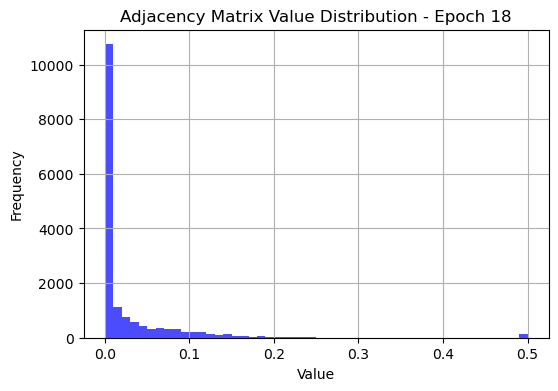

Most similar patients: 30 and 100
Patient 30 attributes:
 [[ 0.62810826  0.31133676  1.5623001  ...  0.52299434 -1.8250008
   2.119728  ]
 [-1.8449441   1.004963   -0.90178466 ...  0.66824114 -0.6964436
   0.11654268]
 [ 1.4789183   1.375038   -0.7879746  ... -0.23972909  1.6275566
  -0.02468248]
 ...
 [ 1.3604395   0.29444966  0.11659831 ... -1.3084743   1.5853022
   1.1298084 ]
 [-2.047641   -0.7794286   0.39044204 ... -0.10512786 -0.25419533
  -0.98082435]
 [ 0.5041369   0.3802781  -1.2937716  ... -1.1074728   0.9273261
   1.097767  ]]
Patient 100 attributes:
 [[ 0.41551974 -0.7599424  -1.0756559  ...  0.9487027   1.9817122
   1.7659872 ]
 [-1.2546104  -0.07807831 -1.6434218  ...  0.2642622  -0.6416996
  -0.24739198]
 [ 0.51014584  0.2069731  -0.6043083  ... -1.9683403  -0.58096284
  -2.0931408 ]
 ...
 [-1.138784   -0.3146207  -0.37533864 ...  0.90458196 -2.2422013
  -0.9518075 ]
 [ 1.7532257  -1.1336701   0.93302727 ... -0.05912229  0.79665446
   1.9554152 ]
 [ 0.9886693   1.590532

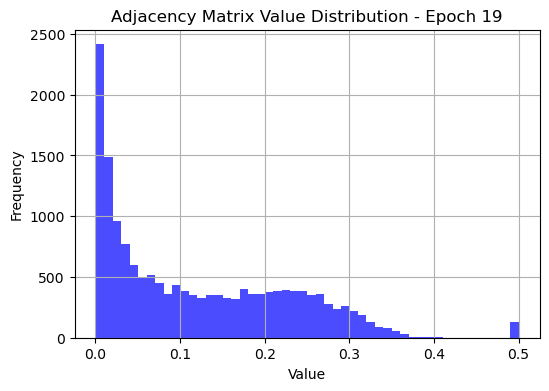

Most similar patients: 78 and 101
Patient 78 attributes:
 [[-0.9858839   0.54031897  2.1126583  ... -0.02576623 -0.16491556
   0.08505563]
 [-0.1623699  -0.22867922 -1.8622986  ...  0.893066   -1.5350691
   0.17623067]
 [-1.0691147   0.3736016   1.1257951  ... -0.42971805 -0.5292914
  -1.9470274 ]
 ...
 [ 0.55051047 -0.88576114  1.1432073  ...  1.1172565   0.45578894
   0.65792745]
 [-0.8536687  -0.01763655  1.0497291  ...  0.37161872  0.47983918
  -0.54979867]
 [-0.01311558 -1.0547986  -0.48790455 ... -3.136263    0.5758574
   0.05330757]]
Patient 101 attributes:
 [[ 1.3439195   3.5543838  -1.6158775  ...  0.34246814  1.8014032
   0.7157943 ]
 [ 2.0558755  -2.3453782   0.5937522  ...  1.6718748  -0.87972295
   0.14364773]
 [ 4.500348    1.9352642   1.507141   ... -2.7866938   2.6474771
   2.9514184 ]
 ...
 [ 1.2885975  -1.0346898   1.8581108  ...  1.0133977  -0.8930244
  -0.6685439 ]
 [ 2.2925649  -0.9794874  -4.2699656  ...  2.6250699  -4.969578
  -1.5108349 ]
 [-0.5443538  -0.264760

C:\anaconda3\envs\graph\Lib\site-packages\matplotlib\axes\_axes.py:6973: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\anaconda3\envs\graph\Lib\site-packages\matplotlib\axes\_axes.py:6974: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

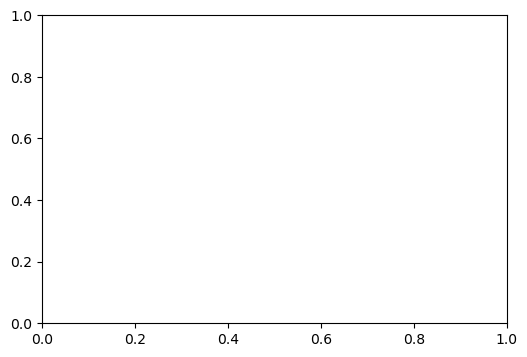

In [138]:
train_model(train_loader, val_loader, num_epochs=30, lr=0.01, alpha=0.1)

In [107]:
def test_model(f1, f2, f3, test_loader, criterion, device):
    f1.eval()
    f2.eval()
    f3.eval()
    
    total_loss, total_correct, total_samples = 0, 0, 0
    all_preds, all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            node_embeddings = f1(batch)
            graph_representations = global_mean_pool(node_embeddings, batch.batch)
            population_graph = f2(graph_representations)
            outputs = f3(graph_representations, population_graph)
            
            loss = criterion(outputs, batch.y)
            total_loss += loss.item()
            
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())

            total_correct += (preds == batch.y).sum().item()
            total_samples += batch.y.size(0)

    acc = total_correct / total_samples
    f1_macro = f1_score(all_labels, all_preds, average="macro")

    print(f"\n🔥 Test Results: Loss={total_loss:.4f} | Accuracy={acc:.4f} | F1-score={f1_macro:.4f}\n")
    
    return total_loss, acc, f1_macro


In [108]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


f1 = NodeLevelModule(num_embeddings=105220, embedding_dim=64, hidden_dim=128, out_dim=32).to(device)
# Load trained models
f2 = PopulationLevelModule(graph_dim=32, latent_dim=16).to(device)
f3 = GNNClassifier(graph_dim=32, num_classes=2405).to(device)

# Load best weights if saved (Optional)
# f1.load_state_dict(torch.load("f1_best.pth"))
# f2.load_state_dict(torch.load("f2_best.pth"))
# f3.load_state_dict(torch.load("f3_best.pth"))

criterion = nn.CrossEntropyLoss()

# Run testing
test_model(f1, f2, f3, test_loader, criterion, device)


ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:
# Save
torch.save(f1.state_dict(), "f1_best.pth")
torch.save(f2.state_dict(), "f2_best.pth")
torch.save(f3.state_dict(), "f3_best.pth")

# Load later
f1.load_state_dict(torch.load("f1_best.pth"))
f2.load_state_dict(torch.load("f2_best.pth"))
f3.load_state_dict(torch.load("f3_best.pth"))
